In [1]:
import torch
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
                "SimianLuo/LCM_Dreamshaper_v7", custom_pipeline="latent_consistency_txt2img", custom_revision="main")

            # To save GPU memory, torch.float16 can be used, but it may compromise image quality.
pipe.to(torch_device="cuda", torch_dtype=torch.float32)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin C:\Users\Nagol\AppData\Local\Programs\Python\Python310\lib\site-packages\bitsandbytes\libbitsandbytes_cuda117.dll
CUDA SETUP: CUDA runtime path found: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7\bin\cudart64_110.dll
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary C:\Users\Nagol\AppData\Local\Programs\Python\Python310\lib\site-packages\bitsandbytes\libbitsandbytes_cuda117.dll...


C:\Users\Nagol\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\Nagol\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\pipeline_utils.py:712: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")
C:\Users\Nagol\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\pipeline_utils.py:715: FutureWarning: `torch_device` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_device", "0.25.0", "")


LatentConsistencyModelPipeline {
  "_class_name": "LatentConsistencyModelPipeline",
  "_diffusers_version": "0.22.0.dev0",
  "_name_or_path": "SimianLuo/LCM_Dreamshaper_v7",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers_modules.git.latent_consistency_txt2img",
    "LCMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
pipe.safety_checker=None

In [3]:
prompt="taylor swift in a red dress"

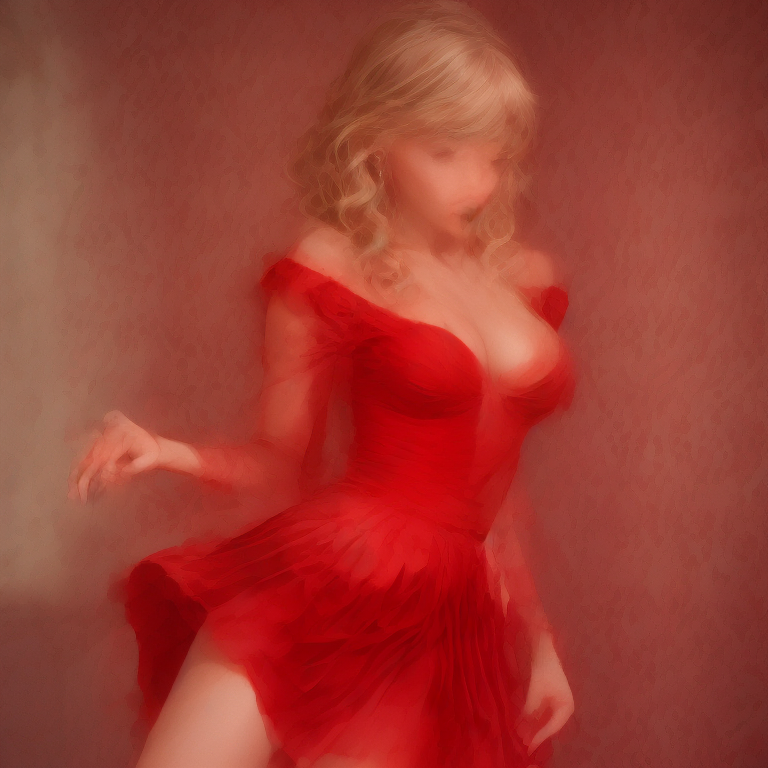

In [5]:
from IPython.display import clear_output


for i in range(1):
    output=pipe(prompt,num_inference_steps=2)
    image=output.images[0]
    clear_output(wait=True)
    display(image)

CPU times: total: 0 ns
Wall time: 1 ms


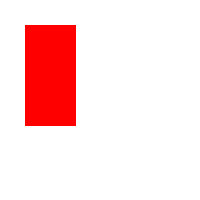

In [6]:
from PIL import Image, ImageDraw

def create_red_rectangle_on_white_bg(x, y, width, height, bg_size=(200, 200)):
    # Create a white background image
    img = Image.new("RGB", bg_size, "white")
    
    # Draw a red rectangle based on the provided coordinates and dimensions
    draw = ImageDraw.Draw(img)
    draw.rectangle([x, y, x + width, y + height], fill="red")
    
    return img

# Call the function and store the result
%time image = create_red_rectangle_on_white_bg(25, 25, 50, 100)

image

In [16]:
# Copyright 2023 Stanford University Team and The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DISCLAIMER: This code is strongly influenced by https://github.com/pesser/pytorch_diffusion
# and https://github.com/hojonathanho/diffusion

import math
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np
import torch
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, ConfigMixin, DiffusionPipeline, SchedulerMixin, UNet2DConditionModel, logging
from diffusers.configuration_utils import register_to_config
from diffusers.image_processor import VaeImageProcessor, PipelineImageInput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.utils import BaseOutput

from diffusers.utils.torch_utils import randn_tensor


import PIL.Image


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


class LatentConsistencyModelPipeline_img2img(DiffusionPipeline):
    _optional_components = ["scheduler"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: "LCMScheduler",
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        scheduler = (
            scheduler
            if scheduler is not None
            else LCMScheduler(
                beta_start=0.00085, beta_end=0.0120, beta_schedule="scaled_linear", prediction_type="epsilon"
            )
        )

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)

    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        prompt_embeds: None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.
        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
        """

        if prompt is not None and isinstance(prompt, str):
            pass
        elif prompt is not None and isinstance(prompt, list):
            len(prompt)
        else:
            prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = self.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        if self.text_encoder is not None:
            prompt_embeds_dtype = self.text_encoder.dtype
        elif self.unet is not None:
            prompt_embeds_dtype = self.unet.dtype
        else:
            prompt_embeds_dtype = prompt_embeds.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # Don't need to get uncond prompt embedding because of LCM Guided Distillation
        return prompt_embeds

    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(image, output_type="pil")
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(feature_extractor_input, return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    def prepare_latents(self, image, timestep, batch_size, num_channels_latents, height, width, dtype, device, latents=None, generator=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        
        if not isinstance(image, (torch.Tensor, PIL.Image.Image, list)):
            raise ValueError(
                f"`image` has to be of type `torch.Tensor`, `PIL.Image.Image` or list but is {type(image)}"
            )

        image = image.to(device=device, dtype=dtype)

        #batch_size = batch_size * num_images_per_prompt

        if image.shape[1] == 4:
            init_latents = image

        else:
            if isinstance(generator, list) and len(generator) != batch_size:
                raise ValueError(
                    f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                    f" size of {batch_size}. Make sure the batch size matches the length of the generators."
                )

            elif isinstance(generator, list):
                init_latents = [
                    self.vae.encode(image[i : i + 1]).latent_dist.sample(generator[i]) for i in range(batch_size)
                ]
                init_latents = torch.cat(init_latents, dim=0)
            else:
                init_latents = self.vae.encode(image).latent_dist.sample(generator)

            init_latents = self.vae.config.scaling_factor * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many initial images as text prompts to suppress this warning."
            )
            #deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents], dim=0)

        shape = init_latents.shape
        noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # get latents
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents
        
        
        
        
        if latents is None:
            latents = torch.randn(shape, dtype=dtype).to(device)
        else:
            latents = latents.to(device)
        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def get_w_embedding(self, w, embedding_dim=512, dtype=torch.float32):
        """
        see https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298
        Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        dtype: data type of the generated embeddings
        Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb
    
    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]

        return timesteps, num_inference_steps - t_start

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: PipelineImageInput = None,
        strength: float = 0.8,
        height: Optional[int] = 768,
        width: Optional[int] = 768,
        guidance_scale: float = 7.5,
        num_images_per_prompt: Optional[int] = 1,
        latents: Optional[torch.FloatTensor] = None,
        num_inference_steps: int = 4,
        lcm_origin_steps: int = 50,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # do_classifier_free_guidance = guidance_scale > 0.0  # In LCM Implementation:  cfg_noise = noise_cond + cfg_scale * (noise_cond - noise_uncond) , (cfg_scale > 0.0 using CFG)

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            prompt_embeds=prompt_embeds,
        )

        # 3.5 encode image
        image = self.image_processor.preprocess(image)

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, lcm_origin_steps)
        #timesteps = self.scheduler.timesteps
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 5. Prepare latent variable
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            image,
            latent_timestep,
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            latents,
        )
        bs = batch_size * num_images_per_prompt

        # 6. Get Guidance Scale Embedding
        w = torch.tensor(guidance_scale).repeat(bs)
        w_embedding = self.get_w_embedding(w, embedding_dim=256).to(device=device, dtype=latents.dtype)

        # 7. LCM MultiStep Sampling Loop:
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                ts = torch.full((bs,), t, device=device, dtype=torch.long)
                latents = latents.to(prompt_embeds.dtype)

                # model prediction (v-prediction, eps, x)
                model_pred = self.unet(
                    latents,
                    ts,
                    timestep_cond=w_embedding,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # compute the previous noisy sample x_t -> x_t-1
                latents, denoised = self.scheduler.step(model_pred, i, t, latents, return_dict=False)

                # # call the callback, if provided
                # if i == len(timesteps) - 1:
                progress_bar.update()

        denoised = denoised.to(prompt_embeds.dtype)
        if not output_type == "latent":
            image = self.vae.decode(denoised / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = denoised
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


@dataclass
# Copied from diffusers.schedulers.scheduling_ddpm.DDPMSchedulerOutput with DDPM->DDIM
class LCMSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's `step` function output.
    Args:
        prev_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample `(x_{t-1})` of previous timestep. `prev_sample` should be used as next model input in the
            denoising loop.
        pred_original_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted denoised sample `(x_{0})` based on the model output from the current timestep.
            `pred_original_sample` can be used to preview progress or for guidance.
    """

    prev_sample: torch.FloatTensor
    denoised: Optional[torch.FloatTensor] = None


# Copied from diffusers.schedulers.scheduling_ddpm.betas_for_alpha_bar
def betas_for_alpha_bar(
    num_diffusion_timesteps,
    max_beta=0.999,
    alpha_transform_type="cosine",
):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].
    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.
    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.
        alpha_transform_type (`str`, *optional*, default to `cosine`): the type of noise schedule for alpha_bar.
                     Choose from `cosine` or `exp`
    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """
    if alpha_transform_type == "cosine":

        def alpha_bar_fn(t):
            return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

    elif alpha_transform_type == "exp":

        def alpha_bar_fn(t):
            return math.exp(t * -12.0)

    else:
        raise ValueError(f"Unsupported alpha_tranform_type: {alpha_transform_type}")

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar_fn(t2) / alpha_bar_fn(t1), max_beta))
    return torch.tensor(betas, dtype=torch.float32)


def rescale_zero_terminal_snr(betas):
    """
    Rescales betas to have zero terminal SNR Based on https://arxiv.org/pdf/2305.08891.pdf (Algorithm 1)
    Args:
        betas (`torch.FloatTensor`):
            the betas that the scheduler is being initialized with.
    Returns:
        `torch.FloatTensor`: rescaled betas with zero terminal SNR
    """
    # Convert betas to alphas_bar_sqrt
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_bar_sqrt = alphas_cumprod.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt**2  # Revert sqrt
    alphas = alphas_bar[1:] / alphas_bar[:-1]  # Revert cumprod
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas

    return betas


class LCMScheduler(SchedulerMixin, ConfigMixin):
    """
    `LCMScheduler` extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with
    non-Markovian guidance.
    This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
    methods the library implements for all schedulers such as loading and saving.
    Args:
        num_train_timesteps (`int`, defaults to 1000):
            The number of diffusion steps to train the model.
        beta_start (`float`, defaults to 0.0001):
            The starting `beta` value of inference.
        beta_end (`float`, defaults to 0.02):
            The final `beta` value.
        beta_schedule (`str`, defaults to `"linear"`):
            The beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        trained_betas (`np.ndarray`, *optional*):
            Pass an array of betas directly to the constructor to bypass `beta_start` and `beta_end`.
        clip_sample (`bool`, defaults to `True`):
            Clip the predicted sample for numerical stability.
        clip_sample_range (`float`, defaults to 1.0):
            The maximum magnitude for sample clipping. Valid only when `clip_sample=True`.
        set_alpha_to_one (`bool`, defaults to `True`):
            Each diffusion step uses the alphas product value at that step and at the previous one. For the final step
            there is no previous alpha. When this option is `True` the previous alpha product is fixed to `1`,
            otherwise it uses the alpha value at step 0.
        steps_offset (`int`, defaults to 0):
            An offset added to the inference steps. You can use a combination of `offset=1` and
            `set_alpha_to_one=False` to make the last step use step 0 for the previous alpha product like in Stable
            Diffusion.
        prediction_type (`str`, defaults to `epsilon`, *optional*):
            Prediction type of the scheduler function; can be `epsilon` (predicts the noise of the diffusion process),
            `sample` (directly predicts the noisy sample`) or `v_prediction` (see section 2.4 of [Imagen
            Video](https://imagen.research.google/video/paper.pdf) paper).
        thresholding (`bool`, defaults to `False`):
            Whether to use the "dynamic thresholding" method. This is unsuitable for latent-space diffusion models such
            as Stable Diffusion.
        dynamic_thresholding_ratio (`float`, defaults to 0.995):
            The ratio for the dynamic thresholding method. Valid only when `thresholding=True`.
        sample_max_value (`float`, defaults to 1.0):
            The threshold value for dynamic thresholding. Valid only when `thresholding=True`.
        timestep_spacing (`str`, defaults to `"leading"`):
            The way the timesteps should be scaled. Refer to Table 2 of the [Common Diffusion Noise Schedules and
            Sample Steps are Flawed](https://huggingface.co/papers/2305.08891) for more information.
        rescale_betas_zero_snr (`bool`, defaults to `False`):
            Whether to rescale the betas to have zero terminal SNR. This enables the model to generate very bright and
            dark samples instead of limiting it to samples with medium brightness. Loosely related to
            [`--offset_noise`](https://github.com/huggingface/diffusers/blob/74fd735eb073eb1d774b1ab4154a0876eb82f055/examples/dreambooth/train_dreambooth.py#L506).
    """

    # _compatibles = [e.name for e in KarrasDiffusionSchedulers]
    order = 1

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
        clip_sample: bool = True,
        set_alpha_to_one: bool = True,
        steps_offset: int = 0,
        prediction_type: str = "epsilon",
        thresholding: bool = False,
        dynamic_thresholding_ratio: float = 0.995,
        clip_sample_range: float = 1.0,
        sample_max_value: float = 1.0,
        timestep_spacing: str = "leading",
        rescale_betas_zero_snr: bool = False,
    ):
        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = (
                torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
            )
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        # Rescale for zero SNR
        if rescale_betas_zero_snr:
            self.betas = rescale_zero_terminal_snr(self.betas)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy().astype(np.int64))

    def scale_model_input(self, sample: torch.FloatTensor, timestep: Optional[int] = None) -> torch.FloatTensor:
        """
        Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
        current timestep.
        Args:
            sample (`torch.FloatTensor`):
                The input sample.
            timestep (`int`, *optional*):
                The current timestep in the diffusion chain.
        Returns:
            `torch.FloatTensor`:
                A scaled input sample.
        """
        return sample

    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)

        return variance

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler._threshold_sample
    def _threshold_sample(self, sample: torch.FloatTensor) -> torch.FloatTensor:
        """
        "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
        prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
        s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
        pixels from saturation at each step. We find that dynamic thresholding results in significantly better
        photorealism as well as better image-text alignment, especially when using very large guidance weights."
        https://arxiv.org/abs/2205.11487
        """
        dtype = sample.dtype
        batch_size, channels, height, width = sample.shape

        if dtype not in (torch.float32, torch.float64):
            sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

        # Flatten sample for doing quantile calculation along each image
        sample = sample.reshape(batch_size, channels * height * width)

        abs_sample = sample.abs()  # "a certain percentile absolute pixel value"

        s = torch.quantile(abs_sample, self.config.dynamic_thresholding_ratio, dim=1)
        s = torch.clamp(
            s, min=1, max=self.config.sample_max_value
        )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]

        s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
        sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

        sample = sample.reshape(batch_size, channels, height, width)
        sample = sample.to(dtype)

        return sample

    def set_timesteps(self, num_inference_steps: int, lcm_origin_steps: int, device: Union[str, torch.device] = None):
        """
        Sets the discrete timesteps used for the diffusion chain (to be run before inference).
        Args:
            num_inference_steps (`int`):
                The number of diffusion steps used when generating samples with a pre-trained model.
        """

        if num_inference_steps > self.config.num_train_timesteps:
            raise ValueError(
                f"`num_inference_steps`: {num_inference_steps} cannot be larger than `self.config.train_timesteps`:"
                f" {self.config.num_train_timesteps} as the unet model trained with this scheduler can only handle"
                f" maximal {self.config.num_train_timesteps} timesteps."
            )

        self.num_inference_steps = num_inference_steps

        # LCM Timesteps Setting:  # Linear Spacing
        c = self.config.num_train_timesteps // lcm_origin_steps
        lcm_origin_timesteps = np.asarray(list(range(1, lcm_origin_steps + 1))) * c - 1  # LCM Training  Steps Schedule
        skipping_step = len(lcm_origin_timesteps) // num_inference_steps
        timesteps = lcm_origin_timesteps[::-skipping_step][:num_inference_steps]  # LCM Inference Steps Schedule

        self.timesteps = torch.from_numpy(timesteps.copy()).to(device)

    def get_scalings_for_boundary_condition_discrete(self, t):
        self.sigma_data = 0.5  # Default: 0.5

        # By dividing 0.1: This is almost a delta function at t=0.
        c_skip = self.sigma_data**2 / ((t / 0.1) ** 2 + self.sigma_data**2)
        c_out = (t / 0.1) / ((t / 0.1) ** 2 + self.sigma_data**2) ** 0.5
        return c_skip, c_out

    def step(
        self,
        model_output: torch.FloatTensor,
        timeindex: int,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        variance_noise: Optional[torch.FloatTensor] = None,
        return_dict: bool = True,
    ) -> Union[LCMSchedulerOutput, Tuple]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).
        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
            eta (`float`):
                The weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`, defaults to `False`):
                If `True`, computes "corrected" `model_output` from the clipped predicted original sample. Necessary
                because predicted original sample is clipped to [-1, 1] when `self.config.clip_sample` is `True`. If no
                clipping has happened, "corrected" `model_output` would coincide with the one provided as input and
                `use_clipped_model_output` has no effect.
            generator (`torch.Generator`, *optional*):
                A random number generator.
            variance_noise (`torch.FloatTensor`):
                Alternative to generating noise with `generator` by directly providing the noise for the variance
                itself. Useful for methods such as [`CycleDiffusion`].
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~schedulers.scheduling_lcm.LCMSchedulerOutput`] or `tuple`.
        Returns:
            [`~schedulers.scheduling_utils.LCMSchedulerOutput`] or `tuple`:
                If return_dict is `True`, [`~schedulers.scheduling_lcm.LCMSchedulerOutput`] is returned, otherwise a
                tuple is returned where the first element is the sample tensor.
        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # 1. get previous step value
        prev_timeindex = timeindex + 1
        if prev_timeindex < len(self.timesteps):
            prev_timestep = self.timesteps[prev_timeindex]
        else:
            prev_timestep = timestep

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        # 3. Get scalings for boundary conditions
        c_skip, c_out = self.get_scalings_for_boundary_condition_discrete(timestep)

        # 4. Different Parameterization:
        parameterization = self.config.prediction_type

        if parameterization == "epsilon":  # noise-prediction
            pred_x0 = (sample - beta_prod_t.sqrt() * model_output) / alpha_prod_t.sqrt()

        elif parameterization == "sample":  # x-prediction
            pred_x0 = model_output

        elif parameterization == "v_prediction":  # v-prediction
            pred_x0 = alpha_prod_t.sqrt() * sample - beta_prod_t.sqrt() * model_output

        # 4. Denoise model output using boundary conditions
        denoised = c_out * pred_x0 + c_skip * sample

        # 5. Sample z ~ N(0, I), For MultiStep Inference
        # Noise is not used for one-step sampling.
        if len(self.timesteps) > 1:
            noise = torch.randn(model_output.shape).to(model_output.device)
            prev_sample = alpha_prod_t_prev.sqrt() * denoised + beta_prod_t_prev.sqrt() * noise
        else:
            prev_sample = denoised

        if not return_dict:
            return (prev_sample, denoised)

        return LCMSchedulerOutput(prev_sample=prev_sample, denoised=denoised)

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler.add_noise
    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler.get_velocity
    def get_velocity(
        self, sample: torch.FloatTensor, noise: torch.FloatTensor, timesteps: torch.IntTensor
    ) -> torch.FloatTensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as sample
        alphas_cumprod = self.alphas_cumprod.to(device=sample.device, dtype=sample.dtype)
        timesteps = timesteps.to(sample.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(sample.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(sample.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        velocity = sqrt_alpha_prod * noise - sqrt_one_minus_alpha_prod * sample
        return velocity

    def __len__(self):
        return self.config.num_train_timesteps


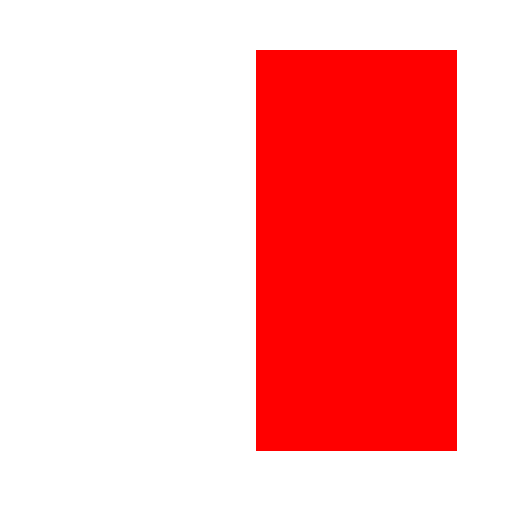

  0%|          | 0/3 [00:00<?, ?it/s]

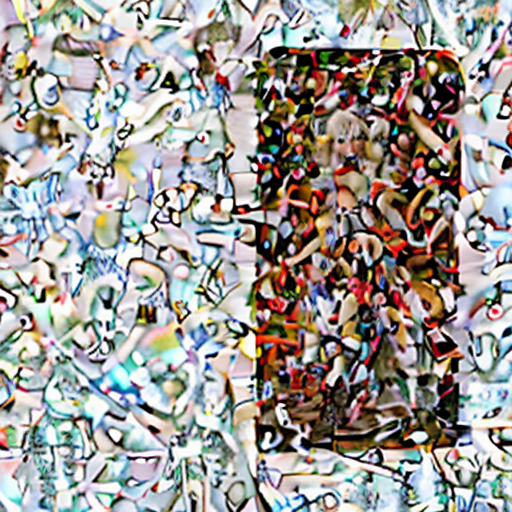

In [17]:
img2img=LatentConsistencyModelPipeline_img2img(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    #scheduler=pipe.scheduler,
    scheduler=None,
    safety_checker=None,
    feature_extractor=pipe.feature_extractor,
    requires_safety_checker=False,
)

img=create_red_rectangle_on_white_bg(50*512/100, 50, 200, 400,bg_size=(512, 512))
display(img)


strength=0.75

result = img2img(prompt,img,strength,num_inference_steps=4)

display(result.images[0])




In [9]:
# Copyright 2023 Stanford University Team and The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DISCLAIMER: This code is strongly influenced by https://github.com/pesser/pytorch_diffusion
# and https://github.com/hojonathanho/diffusion

import math
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np
import torch
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, ConfigMixin, DiffusionPipeline, SchedulerMixin, UNet2DConditionModel, logging
from diffusers.configuration_utils import register_to_config
from diffusers.image_processor import VaeImageProcessor, PipelineImageInput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.utils import BaseOutput

from diffusers.utils.torch_utils import randn_tensor


import PIL.Image


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


class LatentConsistencyModelPipeline_img2img(DiffusionPipeline):
    _optional_components = ["scheduler"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: "LCMScheduler",
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        scheduler = (
            scheduler
            if scheduler is not None
            else LCMScheduler_X(
                beta_start=0.00085, beta_end=0.0120, beta_schedule="scaled_linear", prediction_type="epsilon"
            )
        )

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)

    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        prompt_embeds: None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.
        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
        """

        if prompt is not None and isinstance(prompt, str):
            pass
        elif prompt is not None and isinstance(prompt, list):
            len(prompt)
        else:
            prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = self.text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            prompt_embeds = prompt_embeds[0]

        if self.text_encoder is not None:
            prompt_embeds_dtype = self.text_encoder.dtype
        elif self.unet is not None:
            prompt_embeds_dtype = self.unet.dtype
        else:
            prompt_embeds_dtype = prompt_embeds.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # Don't need to get uncond prompt embedding because of LCM Guided Distillation
        return prompt_embeds

    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(image, output_type="pil")
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(feature_extractor_input, return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    def prepare_latents(self, image, timestep, batch_size, num_channels_latents, height, width, dtype, device, latents=None, generator=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        
        if not isinstance(image, (torch.Tensor, PIL.Image.Image, list)):
            raise ValueError(
                f"`image` has to be of type `torch.Tensor`, `PIL.Image.Image` or list but is {type(image)}"
            )

        image = image.to(device=device, dtype=dtype)

        #batch_size = batch_size * num_images_per_prompt

        if image.shape[1] == 4:
            init_latents = image

        else:
            if isinstance(generator, list) and len(generator) != batch_size:
                raise ValueError(
                    f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                    f" size of {batch_size}. Make sure the batch size matches the length of the generators."
                )

            elif isinstance(generator, list):
                init_latents = [
                    self.vae.encode(image[i : i + 1]).latent_dist.sample(generator[i]) for i in range(batch_size)
                ]
                init_latents = torch.cat(init_latents, dim=0)
            else:
                init_latents = self.vae.encode(image).latent_dist.sample(generator)

            init_latents = self.vae.config.scaling_factor * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many initial images as text prompts to suppress this warning."
            )
            #deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents], dim=0)

        shape = init_latents.shape
        noise = randn_tensor(shape, generator=generator, device=device, dtype=dtype)

        # get latents
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents
        
        
        
        
        if latents is None:
            latents = torch.randn(shape, dtype=dtype).to(device)
        else:
            latents = latents.to(device)
        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def get_w_embedding(self, w, embedding_dim=512, dtype=torch.float32):
        """
        see https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298
        Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        dtype: data type of the generated embeddings
        Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb
    
    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]

        return timesteps, num_inference_steps - t_start

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: PipelineImageInput = None,
        strength: float = 0.8,
        height: Optional[int] = 768,
        width: Optional[int] = 768,
        guidance_scale: float = 7.5,
        num_images_per_prompt: Optional[int] = 1,
        latents: Optional[torch.FloatTensor] = None,
        num_inference_steps: int = 4,
        lcm_origin_steps: int = 50,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # do_classifier_free_guidance = guidance_scale > 0.0  # In LCM Implementation:  cfg_noise = noise_cond + cfg_scale * (noise_cond - noise_uncond) , (cfg_scale > 0.0 using CFG)

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            prompt_embeds=prompt_embeds,
        )

        # 3.5 encode image
        image = self.image_processor.preprocess(image)

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(strength,num_inference_steps, lcm_origin_steps)
        #timesteps = self.scheduler.timesteps
        #timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, 1.0, device)
        timesteps = self.scheduler.timesteps
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        print("timesteps: ", timesteps)

        # 5. Prepare latent variable
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            image,
            latent_timestep,
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            latents,
        )
        bs = batch_size * num_images_per_prompt

        # 6. Get Guidance Scale Embedding
        w = torch.tensor(guidance_scale).repeat(bs)
        w_embedding = self.get_w_embedding(w, embedding_dim=256).to(device=device, dtype=latents.dtype)

        # 7. LCM MultiStep Sampling Loop:
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                ts = torch.full((bs,), t, device=device, dtype=torch.long)
                latents = latents.to(prompt_embeds.dtype)

                # model prediction (v-prediction, eps, x)
                model_pred = self.unet(
                    latents,
                    ts,
                    timestep_cond=w_embedding,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    return_dict=False,
                )[0]

                # compute the previous noisy sample x_t -> x_t-1
                latents, denoised = self.scheduler.step(model_pred, i, t, latents, return_dict=False)

                # # call the callback, if provided
                # if i == len(timesteps) - 1:
                progress_bar.update()

        denoised = denoised.to(prompt_embeds.dtype)
        if not output_type == "latent":
            image = self.vae.decode(denoised / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = denoised
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


@dataclass
# Copied from diffusers.schedulers.scheduling_ddpm.DDPMSchedulerOutput with DDPM->DDIM
class LCMSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's `step` function output.
    Args:
        prev_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample `(x_{t-1})` of previous timestep. `prev_sample` should be used as next model input in the
            denoising loop.
        pred_original_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted denoised sample `(x_{0})` based on the model output from the current timestep.
            `pred_original_sample` can be used to preview progress or for guidance.
    """

    prev_sample: torch.FloatTensor
    denoised: Optional[torch.FloatTensor] = None


# Copied from diffusers.schedulers.scheduling_ddpm.betas_for_alpha_bar
def betas_for_alpha_bar(
    num_diffusion_timesteps,
    max_beta=0.999,
    alpha_transform_type="cosine",
):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].
    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.
    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.
        alpha_transform_type (`str`, *optional*, default to `cosine`): the type of noise schedule for alpha_bar.
                     Choose from `cosine` or `exp`
    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """
    if alpha_transform_type == "cosine":

        def alpha_bar_fn(t):
            return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

    elif alpha_transform_type == "exp":

        def alpha_bar_fn(t):
            return math.exp(t * -12.0)

    else:
        raise ValueError(f"Unsupported alpha_tranform_type: {alpha_transform_type}")

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar_fn(t2) / alpha_bar_fn(t1), max_beta))
    return torch.tensor(betas, dtype=torch.float32)


def rescale_zero_terminal_snr(betas):
    """
    Rescales betas to have zero terminal SNR Based on https://arxiv.org/pdf/2305.08891.pdf (Algorithm 1)
    Args:
        betas (`torch.FloatTensor`):
            the betas that the scheduler is being initialized with.
    Returns:
        `torch.FloatTensor`: rescaled betas with zero terminal SNR
    """
    # Convert betas to alphas_bar_sqrt
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_bar_sqrt = alphas_cumprod.sqrt()

    # Store old values.
    alphas_bar_sqrt_0 = alphas_bar_sqrt[0].clone()
    alphas_bar_sqrt_T = alphas_bar_sqrt[-1].clone()

    # Shift so the last timestep is zero.
    alphas_bar_sqrt -= alphas_bar_sqrt_T

    # Scale so the first timestep is back to the old value.
    alphas_bar_sqrt *= alphas_bar_sqrt_0 / (alphas_bar_sqrt_0 - alphas_bar_sqrt_T)

    # Convert alphas_bar_sqrt to betas
    alphas_bar = alphas_bar_sqrt**2  # Revert sqrt
    alphas = alphas_bar[1:] / alphas_bar[:-1]  # Revert cumprod
    alphas = torch.cat([alphas_bar[0:1], alphas])
    betas = 1 - alphas

    return betas


class LCMScheduler_X(SchedulerMixin, ConfigMixin):
    """
    `LCMScheduler` extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with
    non-Markovian guidance.
    This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
    methods the library implements for all schedulers such as loading and saving.
    Args:
        num_train_timesteps (`int`, defaults to 1000):
            The number of diffusion steps to train the model.
        beta_start (`float`, defaults to 0.0001):
            The starting `beta` value of inference.
        beta_end (`float`, defaults to 0.02):
            The final `beta` value.
        beta_schedule (`str`, defaults to `"linear"`):
            The beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        trained_betas (`np.ndarray`, *optional*):
            Pass an array of betas directly to the constructor to bypass `beta_start` and `beta_end`.
        clip_sample (`bool`, defaults to `True`):
            Clip the predicted sample for numerical stability.
        clip_sample_range (`float`, defaults to 1.0):
            The maximum magnitude for sample clipping. Valid only when `clip_sample=True`.
        set_alpha_to_one (`bool`, defaults to `True`):
            Each diffusion step uses the alphas product value at that step and at the previous one. For the final step
            there is no previous alpha. When this option is `True` the previous alpha product is fixed to `1`,
            otherwise it uses the alpha value at step 0.
        steps_offset (`int`, defaults to 0):
            An offset added to the inference steps. You can use a combination of `offset=1` and
            `set_alpha_to_one=False` to make the last step use step 0 for the previous alpha product like in Stable
            Diffusion.
        prediction_type (`str`, defaults to `epsilon`, *optional*):
            Prediction type of the scheduler function; can be `epsilon` (predicts the noise of the diffusion process),
            `sample` (directly predicts the noisy sample`) or `v_prediction` (see section 2.4 of [Imagen
            Video](https://imagen.research.google/video/paper.pdf) paper).
        thresholding (`bool`, defaults to `False`):
            Whether to use the "dynamic thresholding" method. This is unsuitable for latent-space diffusion models such
            as Stable Diffusion.
        dynamic_thresholding_ratio (`float`, defaults to 0.995):
            The ratio for the dynamic thresholding method. Valid only when `thresholding=True`.
        sample_max_value (`float`, defaults to 1.0):
            The threshold value for dynamic thresholding. Valid only when `thresholding=True`.
        timestep_spacing (`str`, defaults to `"leading"`):
            The way the timesteps should be scaled. Refer to Table 2 of the [Common Diffusion Noise Schedules and
            Sample Steps are Flawed](https://huggingface.co/papers/2305.08891) for more information.
        rescale_betas_zero_snr (`bool`, defaults to `False`):
            Whether to rescale the betas to have zero terminal SNR. This enables the model to generate very bright and
            dark samples instead of limiting it to samples with medium brightness. Loosely related to
            [`--offset_noise`](https://github.com/huggingface/diffusers/blob/74fd735eb073eb1d774b1ab4154a0876eb82f055/examples/dreambooth/train_dreambooth.py#L506).
    """

    # _compatibles = [e.name for e in KarrasDiffusionSchedulers]
    order = 1

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
        clip_sample: bool = True,
        set_alpha_to_one: bool = True,
        steps_offset: int = 0,
        prediction_type: str = "epsilon",
        thresholding: bool = False,
        dynamic_thresholding_ratio: float = 0.995,
        clip_sample_range: float = 1.0,
        sample_max_value: float = 1.0,
        timestep_spacing: str = "leading",
        rescale_betas_zero_snr: bool = False,
    ):
        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = (
                torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
            )
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        # Rescale for zero SNR
        if rescale_betas_zero_snr:
            self.betas = rescale_zero_terminal_snr(self.betas)

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy().astype(np.int64))

    def scale_model_input(self, sample: torch.FloatTensor, timestep: Optional[int] = None) -> torch.FloatTensor:
        """
        Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
        current timestep.
        Args:
            sample (`torch.FloatTensor`):
                The input sample.
            timestep (`int`, *optional*):
                The current timestep in the diffusion chain.
        Returns:
            `torch.FloatTensor`:
                A scaled input sample.
        """
        return sample

    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)

        return variance

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler._threshold_sample
    def _threshold_sample(self, sample: torch.FloatTensor) -> torch.FloatTensor:
        """
        "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
        prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
        s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
        pixels from saturation at each step. We find that dynamic thresholding results in significantly better
        photorealism as well as better image-text alignment, especially when using very large guidance weights."
        https://arxiv.org/abs/2205.11487
        """
        dtype = sample.dtype
        batch_size, channels, height, width = sample.shape

        if dtype not in (torch.float32, torch.float64):
            sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

        # Flatten sample for doing quantile calculation along each image
        sample = sample.reshape(batch_size, channels * height * width)

        abs_sample = sample.abs()  # "a certain percentile absolute pixel value"

        s = torch.quantile(abs_sample, self.config.dynamic_thresholding_ratio, dim=1)
        s = torch.clamp(
            s, min=1, max=self.config.sample_max_value
        )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]

        s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
        sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

        sample = sample.reshape(batch_size, channels, height, width)
        sample = sample.to(dtype)

        return sample

    def set_timesteps(self, stength, num_inference_steps: int, lcm_origin_steps: int, device: Union[str, torch.device] = None):
        """
        Sets the discrete timesteps used for the diffusion chain (to be run before inference).
        Args:
            num_inference_steps (`int`):
                The number of diffusion steps used when generating samples with a pre-trained model.
        """

        if num_inference_steps > self.config.num_train_timesteps:
            raise ValueError(
                f"`num_inference_steps`: {num_inference_steps} cannot be larger than `self.config.train_timesteps`:"
                f" {self.config.num_train_timesteps} as the unet model trained with this scheduler can only handle"
                f" maximal {self.config.num_train_timesteps} timesteps."
            )

        self.num_inference_steps = num_inference_steps

        # LCM Timesteps Setting:  # Linear Spacing
        c = self.config.num_train_timesteps // lcm_origin_steps
        lcm_origin_timesteps = np.asarray(list(range(1, int(lcm_origin_steps*stength) + 1))) * c - 1  # LCM Training  Steps Schedule
        skipping_step = len(lcm_origin_timesteps) // num_inference_steps
        timesteps = lcm_origin_timesteps[::-skipping_step][:num_inference_steps]  # LCM Inference Steps Schedule

        self.timesteps = torch.from_numpy(timesteps.copy()).to(device)

    def get_scalings_for_boundary_condition_discrete(self, t):
        self.sigma_data = 0.5  # Default: 0.5

        # By dividing 0.1: This is almost a delta function at t=0.
        c_skip = self.sigma_data**2 / ((t / 0.1) ** 2 + self.sigma_data**2)
        c_out = (t / 0.1) / ((t / 0.1) ** 2 + self.sigma_data**2) ** 0.5
        return c_skip, c_out

    def step(
        self,
        model_output: torch.FloatTensor,
        timeindex: int,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        variance_noise: Optional[torch.FloatTensor] = None,
        return_dict: bool = True,
    ) -> Union[LCMSchedulerOutput, Tuple]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
        process from the learned model outputs (most often the predicted noise).
        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`float`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
            eta (`float`):
                The weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`, defaults to `False`):
                If `True`, computes "corrected" `model_output` from the clipped predicted original sample. Necessary
                because predicted original sample is clipped to [-1, 1] when `self.config.clip_sample` is `True`. If no
                clipping has happened, "corrected" `model_output` would coincide with the one provided as input and
                `use_clipped_model_output` has no effect.
            generator (`torch.Generator`, *optional*):
                A random number generator.
            variance_noise (`torch.FloatTensor`):
                Alternative to generating noise with `generator` by directly providing the noise for the variance
                itself. Useful for methods such as [`CycleDiffusion`].
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~schedulers.scheduling_lcm.LCMSchedulerOutput`] or `tuple`.
        Returns:
            [`~schedulers.scheduling_utils.LCMSchedulerOutput`] or `tuple`:
                If return_dict is `True`, [`~schedulers.scheduling_lcm.LCMSchedulerOutput`] is returned, otherwise a
                tuple is returned where the first element is the sample tensor.
        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # 1. get previous step value
        prev_timeindex = timeindex + 1
        if prev_timeindex < len(self.timesteps):
            prev_timestep = self.timesteps[prev_timeindex]
        else:
            prev_timestep = timestep

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        # 3. Get scalings for boundary conditions
        c_skip, c_out = self.get_scalings_for_boundary_condition_discrete(timestep)

        # 4. Different Parameterization:
        parameterization = self.config.prediction_type

        if parameterization == "epsilon":  # noise-prediction
            pred_x0 = (sample - beta_prod_t.sqrt() * model_output) / alpha_prod_t.sqrt()

        elif parameterization == "sample":  # x-prediction
            pred_x0 = model_output

        elif parameterization == "v_prediction":  # v-prediction
            pred_x0 = alpha_prod_t.sqrt() * sample - beta_prod_t.sqrt() * model_output

        # 4. Denoise model output using boundary conditions
        denoised = c_out * pred_x0 + c_skip * sample

        # 5. Sample z ~ N(0, I), For MultiStep Inference
        # Noise is not used for one-step sampling.
        if len(self.timesteps) > 1:
            noise = torch.randn(model_output.shape).to(model_output.device)
            prev_sample = alpha_prod_t_prev.sqrt() * denoised + beta_prod_t_prev.sqrt() * noise
        else:
            prev_sample = denoised

        if not return_dict:
            return (prev_sample, denoised)

        return LCMSchedulerOutput(prev_sample=prev_sample, denoised=denoised)

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler.add_noise
    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as original_samples
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler.get_velocity
    def get_velocity(
        self, sample: torch.FloatTensor, noise: torch.FloatTensor, timesteps: torch.IntTensor
    ) -> torch.FloatTensor:
        # Make sure alphas_cumprod and timestep have same device and dtype as sample
        alphas_cumprod = self.alphas_cumprod.to(device=sample.device, dtype=sample.dtype)
        timesteps = timesteps.to(sample.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(sample.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(sample.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        velocity = sqrt_alpha_prod * noise - sqrt_one_minus_alpha_prod * sample
        return velocity

    def __len__(self):
        return self.config.num_train_timesteps


In [10]:
img2img=LatentConsistencyModelPipeline_img2img(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    #scheduler=pipe.scheduler,
    scheduler=None,
    safety_checker=None,
    feature_extractor=pipe.feature_extractor,
    requires_safety_checker=False,
)

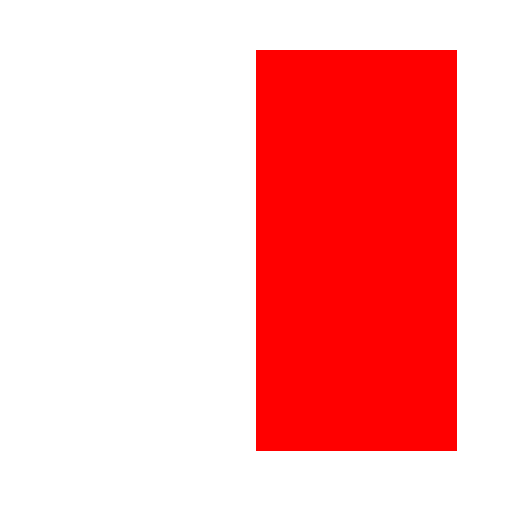

In [11]:
img=create_red_rectangle_on_white_bg(50*512/100, 50, 200, 400,bg_size=(512, 512))
img

timesteps:  tensor([739, 559, 379, 199], dtype=torch.int32)


  0%|          | 0/4 [00:00<?, ?it/s]

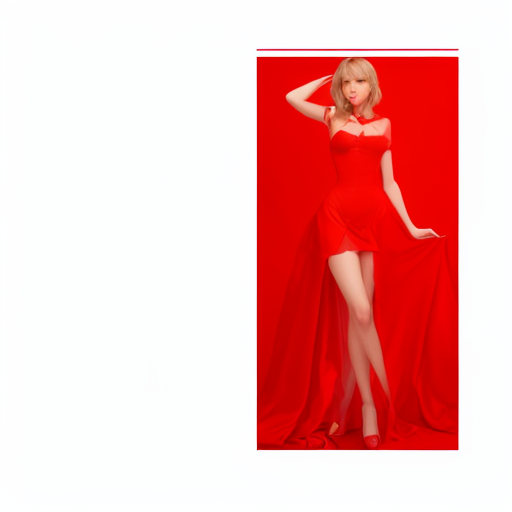

In [14]:
strength=0.75

result = img2img(prompt,img,strength,num_inference_steps=4)

result.images[0]

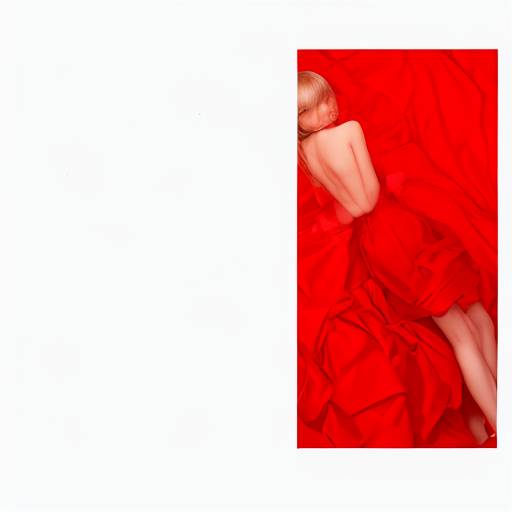

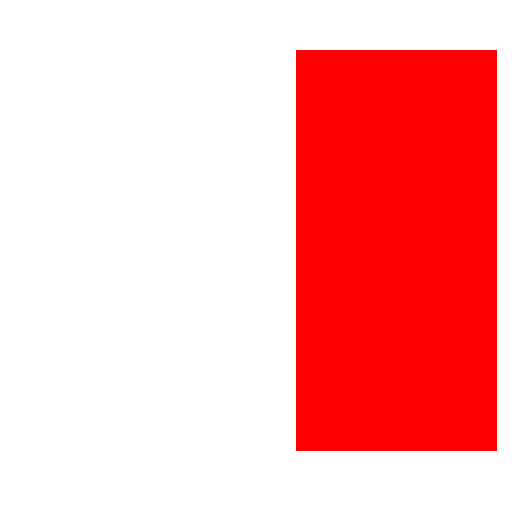

In [105]:
strength=0.7

animation_frames=20

prompt="taylor swift in a red dress"

for i in range(animation_frames):
    img=create_red_rectangle_on_white_bg(i*(512-200)/animation_frames, 50, 200, 400,bg_size=(512, 512))
    result = img2img(prompt,img,strength,num_inference_steps=4)
    image=result.images[0]
    clear_output(wait=True)
    display(image)
    display(img)